# Wetterstation Kloten

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
from scipy import integrate
from scipy import optimize

1. Import der Daten
   - Beschreibt die Datenstruktur.
   - Zeigt auf, wie viele Messungen es sind.

In [2]:
#load csv file
weather = np.loadtxt('Zürich21-22-GruppeG.csv', skiprows=1, delimiter=';', dtype=str)

#select data for Kloten
klo_weather = [row for row in weather if row[0] == 'KLO'] #klo_weather -> schönere lösung gruppe F!!!!

In [3]:
#Daten transponieren
klo_weather_t = np.transpose(klo_weather)

#Arrays für die Daten bereitstellen
time= klo_weather_t[1].astype("datetime64[m]").astype(float)
pressure = klo_weather_t[2].astype(float)
temp = klo_weather_t[3].astype(float)
rain = klo_weather_t[4].astype(float)
sunshine = klo_weather_t[5].astype(float)
time_diff = klo_weather_t[6].astype(float)

Beschreibung der Daten:
- #stn: Stationnummer oder ID der Wetterstation
- time: Zeitpunkt der Messung im Format JJJJMMDDhhmm
- prestah0: Luftdruck auf Stationshöhe (in hPa)
- tre200h0: Lufttemperatur in 2m Höhe (in Grad Celsius)
- rre150h0: Niederschlagssumme (in mm) der letzten 6 Minuten
- su2000h0: Sonnenscheindauer in Minuten der letzten Stunde <- stimmt nöööööd!!!!... > korrigiere
- time_diff: Zeitdifferenz zur vorigen Messung in Minuten

In [4]:
print("Anzahl Messungen:", len(klo_weather))

Anzahl Messungen: 7473


2. Da einige Datenpunkte fehlen, müsst ihr diese interpolieren.
   - Wählt dazu eine geeignete Methode und begründet eure Wahl.
   - Führt die Methode durch, um eine interpolierte Version der Daten mit mindestens doppelt so vielen Punkten zu erzeugen.

In [5]:
#Anzahl stunden die wir interpoliert haben wollen -> bessere beschreibung!!!!!!
max = int(np.max(time_diff))

#Anzahl Zeitpunkte verdoppeln für die Interpolation (+1 damit es aufgeht auf halbstundenbasis)
time_new = np.linspace(time.min(), time.max(), ((2*max)+1), dtype=int) 

#Daten mit verschiedenen Methoden interpolieren
f_cubic     = interp1d(time, klo_weather_t[2:6], kind='cubic')
f_linear    = interp1d(time, klo_weather_t[2:6], kind = 'linear')

pressure_inter_cubic, temp_inter_cubic, rain_inter_cubic, sunshine_inter_cubic       = f_cubic(time_new)
pressure_inter_linear, temp_inter_linear, rain_inter_linear, sunshine_inter_linear   = f_linear(time_new)

#time zu datetime umwandeln für spätere Darstellungszwecke
time_datetime = time.astype("datetime64[m]")
time_datetime_inter = time_new.astype("datetime64[m]") 
#time_datetime_inter = time_new.astype(datetime.datetime) -> funktioniert nicht beim ploten wieso???? -> wäre schöner da es später wieder umgewandelt werden muss im Tagesdurschnittsloop

In [6]:
#daten für demo
time_diff_demo = time_datetime[:25]
max_demo = 2 * int(np.max(time_diff[:25])) + 1 #Für den Index beim Plotten der Demo-Daten

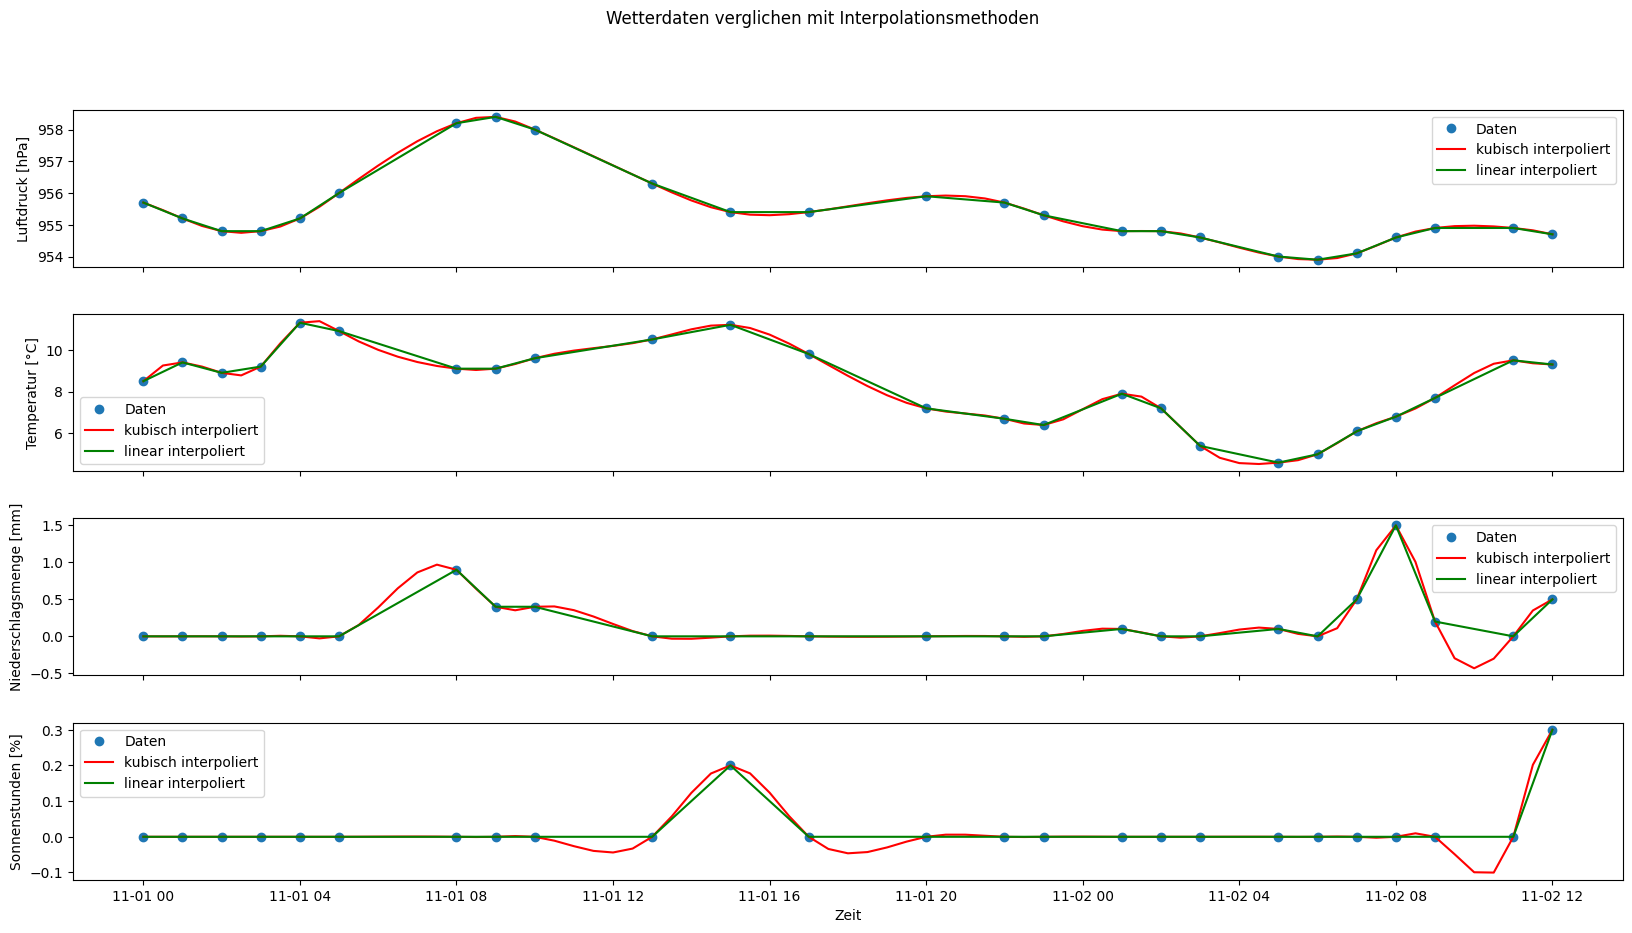

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.plot(time_diff_demo, pressure[:25], 'o', label='Daten')
ax1.plot(time_datetime_inter[0:max_demo], pressure_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax1.plot(time_datetime_inter[0:max_demo], pressure_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax1.set_ylabel('Luftdruck [hPa]')
ax1.legend()

ax2.plot(time_diff_demo, temp[:25], 'o', label='Daten')
ax2.plot(time_datetime_inter[0:max_demo], temp_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax2.plot(time_datetime_inter[0:max_demo], temp_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax2.set_ylabel('Temperatur [°C]')
ax2.legend()

ax3.plot(time_diff_demo, rain[:25], 'o', label='Daten')
ax3.plot(time_datetime_inter[0:max_demo], rain_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax3.plot(time_datetime_inter[0:max_demo], rain_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax3.set_ylabel('Niederschlagsmenge [mm]')
ax3.legend()

ax4.plot(time_diff_demo, sunshine[:25], 'o', label='Daten')
ax4.plot(time_datetime_inter[0:max_demo], sunshine_inter_cubic[0:max_demo], 'r-', label='kubisch interpoliert')
ax4.plot(time_datetime_inter[0:max_demo], sunshine_inter_linear[0:max_demo], 'g-', label='linear interpoliert')
ax4.set_ylabel('Sonnenstunden [%]')
ax4.legend()

plt.xlabel('Zeit') # Zeit????? -> bessere beschriftung????
plt.suptitle('Wetterdaten verglichen mit Interpolationsmethoden') #besserer Titel bitte!!!!!!!
plt.show()

Entscheidung: 
 Luftdruck und Temperatur -> kubisch -> Wieso????
 Niederschlagsmenge und Sonnenstunden -> linear -> bei kubisch entstehen nicht reale Daten -> negative Niederschlagsmenden und Sonnenstunden isnd nicht möglich

3. Ihr sollt alle Variablen (Luftdruck, Temperatur, Regenmenge und Sonnenstunden) über einen selbstgewählten Zeitraum darstellen. 
   - Basisvariante: Wähle einen interessanten Zeitraum von 1-2 Wochen.
   - Schwierigere Variante (mehr Punkte): Errechne tageweise Durchschnitte, um die Variablen in einem grösseren Zeitraum (mehrere Monate/Quartal) darzustellen.

In [8]:
#Variablen instanzieren
daily_pressure = np.array([]).astype(float)
daily_average_pressure = 0

daily_temp = np.array([]).astype(float)
daily_average_temp = 0

daily_rain = np.array([]).astype(float)
daily_average_rain = 0

daily_sunshine = np.array([]).astype(float)
daily_average_sun = 0

#Versuch mit date_array
date = np.array([]).astype(datetime.date)
#date = np.empty(365, dtype='datetime64[D]')


#Tagesdurschnitt berechnen (pro Tag 48 Messwerte)
for i in range(len(time_new)):
    daily_average_pressure += pressure_inter_cubic[i]
    daily_average_temp += temp_inter_cubic[i]
    daily_average_rain += rain_inter_linear[i]
    daily_average_sun += sunshine_inter_linear[i]
    if (i+1) % 48 == 0:
        daily_pressure = np.append(daily_pressure, daily_average_pressure/48)
        daily_average_pressure = 0
        daily_temp = np.append(daily_temp, daily_average_temp/48)
        daily_average_temp = 0
        daily_rain = np.append(daily_rain, daily_average_rain/48)
        daily_average_rain = 0
        daily_sunshine = np.append(daily_sunshine, daily_average_sun/48)
        daily_average_sun = 0
        date = np.append(date, time_datetime_inter[i].astype(datetime.datetime).date())

#für den letzten Tag wird der Durchschnitt nicht gerechnet, da die letzte stunde fehlt und somit wir die Daten für genau ein Jahr haben.

In [9]:
#wird nicht mehr benötigt!!!!!!
#start_date = datetime.date(2021, 11, 1)  # Startdatum festlegen
#end_date = datetime.date(2022, 10, 31)  # Enddatum festlegen
#num_days = (end_date - start_date).days + 1  # Anzahl der Tage berechnen

#date_array = np.array([start_date + datetime.timedelta(days=x) for x in range(num_days)])  # Array von Datumswerten generieren

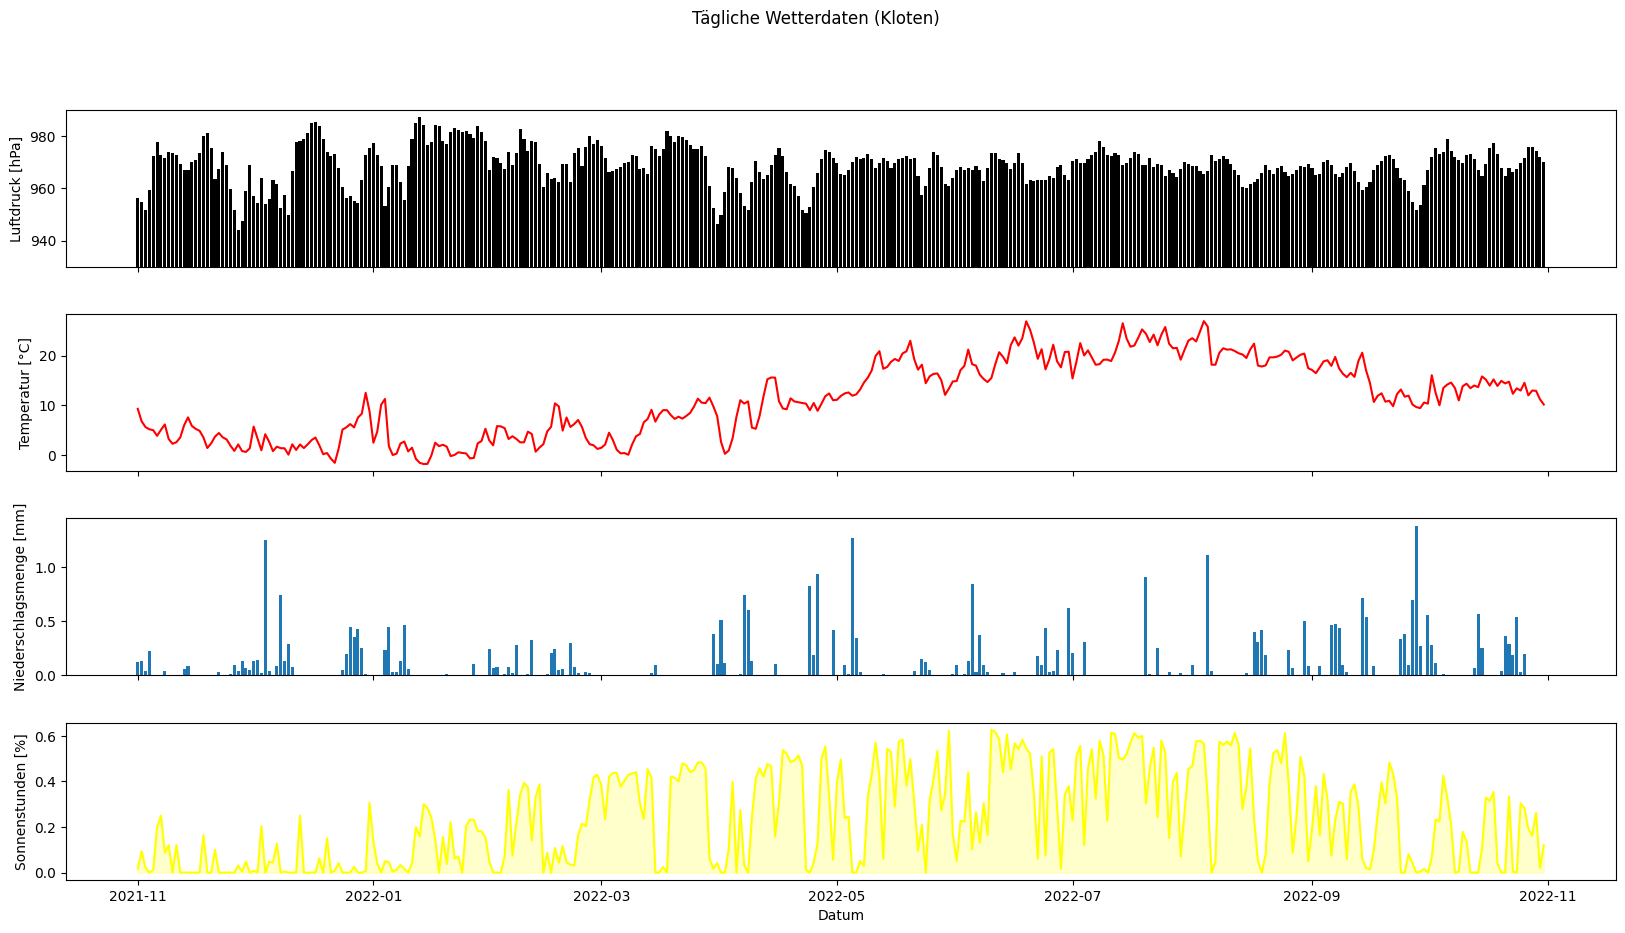

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(20,10))
fig.subplots_adjust(wspace=0.5, hspace=0.3)

ax1.bar(date, daily_pressure, color='black')
ax1.set_ylim(930,990)
ax1.set_ylabel('Luftdruck [hPa]')


ax2.plot(date, daily_temp, color='red')
ax2.set_ylabel('Temperatur [°C]')

ax3.bar(date, daily_rain)
ax3.set_ylabel('Niederschlagsmenge [mm]')

ax4.plot(date, daily_sunshine, color='yellow')
ax4.fill_between(date, daily_sunshine, 0, alpha=0.2, color='yellow')
#ax4.set_ylim(0,1)
ax4.set_ylabel('Sonnenstunden [%]')

plt.xlabel('Datum')
#plt.xlim(start_date, end_date)
plt.suptitle('Tägliche Wetterdaten (Kloten)')
plt.show()

4. Für die folgenden Punkte sollt ihr eine der Variablen auswählen.
   - Entweder Luftdruck, Temperatur, Regenmenge oder Sonnenstunden

Temperature it is!

5. Vergleicht die ursprünglichen Daten mit den interpolierten Daten und zeigt eure Erkenntnisse auf. 
   - Hier könnt ihr euch z.B. fragen, wie sich unterschiedliche Interpolationsmethoden verhalten.

In [11]:
f_linear_temp = interp1d(time_diff, klo_weather_t[3:4], kind = 'linear') 

6. Berechnet Nullstellen bzw. Schnittpunkte mit einem Schwellenwert und überlegt euch, welche Aussagen ihr daraus ableiten könnt.
   - Ihr könntet z.B. sagen: "In Davos hatten wir im Winter X-mal weniger als Null Grad." oder "An welchen Tagen wurde die Regenmenge XY erreicht?".

In [12]:
print(f_linear_temp(0))
zero = optimize.newton(f_linear_temp, 1000)
print(zero)
#print(temp_inter_linear[1900:2000])

zero1 = optimize.newton(f_linear_temp, 40)
print(zero1)

[8.5]
[[[[[[[988.17647059]]]]]]]
[[[[[[[[[[[223.25]]]]]]]]]]]


7. Mithilfe der Ableitung soll nach grossen Änderungen in den Daten gesucht werden. 
   - So könnt ihr z.B. sagen: "Am Tag X hatten wir die grösste Änderungsrate des Luftdrucks".

In [13]:
#Steigung der Temperaturen berechnen
df = np.gradient(temp_inter_cubic)

#Index der kleinste steigung bzw. grösste Abnahme auslesen
i_min = np.argmin(df)
#Index der grössten steigung auslesen
i_max = np.argmax(df) 

print("maximale Abnahme:",(df[i_min]), "am", (time_datetime_inter[i_min])) 
print("maximale Zunahme:",(df[i_max]), "am", (time_datetime_inter[i_max]))

maximale Abnahme: -3.8999999999999986 am 2022-08-05T17:30
maximale Zunahme: 2.3 am 2022-02-24T09:30


In [14]:
#überprüfung der werte
print(temp_inter_cubic[i_min-2:i_min+1])
print(temp_inter_cubic[i_max-2:i_max+1])

[32.81341263 31.5        27.88270549]
[-0.30347866  1.4         3.63730922]


8. Benutze die Integration, um gewisse Durchschnittswerte über einen definierten Zeitraum zu berechnen.
   - So könnt ihr z.B. die durchschnittlichen Sonnenstunden über den Sommer aufzeigen.

In [15]:
def mean_func(func, a, b):
    integral, error = integrate.quad(func, a, b)
    return integral / (b - a)

In [16]:
mean_temp = mean_func(f_linear_temp, 0, 500)
print(mean_temp)

np.mean(temp_inter_cubic[:500]) # wäre das nicht einfacher und genauer?

4.6858622096793425


/var/folders/q8/hvsp1b0j5fsbxf6r91xb9xrm0000gp/T/ipykernel_89328/4244152064.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = integrate.quad(func, a, b)


5.01396117942942

In [17]:
#Zeitraum muss noch angepasst werden
ausgewählter_zeitraum_x = time_datetime_inter[:500]
ausgewählter_zeitraum_y = temp_inter_cubic[:500]

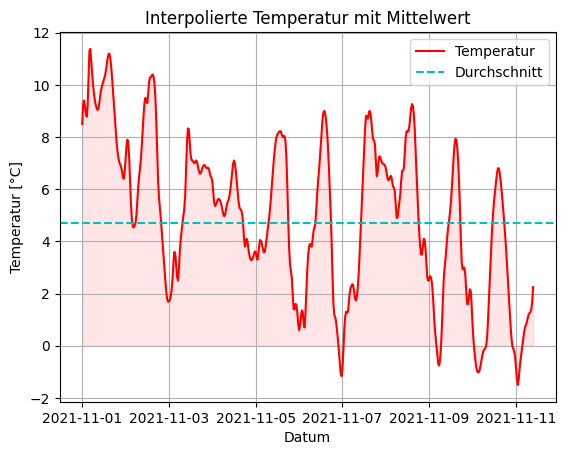

Die Durschnittstemperatur durch den Sommer betrug 4.6858622096793425 °C


In [18]:
plt.plot(ausgewählter_zeitraum_x, ausgewählter_zeitraum_y, color='red', label='Temperatur')
plt.fill_between(ausgewählter_zeitraum_x, ausgewählter_zeitraum_y, alpha=0.1, color='red')
plt.axhline(y=mean_temp, color='c', linestyle='--', label='Durchschnitt')
plt.xlabel("Datum")
plt.ylabel("Temperatur [°C]")
plt.title("Interpolierte Temperatur mit Mittelwert")
plt.legend()
plt.grid()
plt.show()

print("Die Durschnittstemperatur durch den Sommer betrug", mean_temp, "°C")